# Лабораторная работа № 4

Задание:
1. Модель должна научиться классифицировать текст
2. Должны выполнены три реализации модели. Реализации должны быть основаны на использовании:
    - одномерной сверточной нейросети
    - рекуррентной нейросети LSTM
    - рекуррентной нейросети GRU
3. Выполнить сравнение полученных результатов и сделать вывод

Исходные данные:
- для обучения: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
- для тестирования: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
- имена классов: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

# Импорт необходимых библиотек

In [ ]:
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import time

# Выбор устройства

In [37]:
device_name = tf.test.gpu_device_name()  # Проверка доступности GPU. Возвращает имя устройства GPU, если оно найдено.
if device_name:
    print(f'Использование GPU: {device_name}')  # Если GPU найдено, выводится имя устройства GPU.
else:
    print('GPU не найдено, использование CPU.')  # Если GPU не найдено, выводится сообщение о использовании CPU.


GPU не найдено, использование CPU.


# Загрузка данных

In [38]:
# Загрузка данных из локальных файлов
train_df = pd.read_csv('train.csv', header=None)  # Загрузка обучающего набора данных из файла train.csv
test_df = pd.read_csv('test.csv', header=None)  # Загрузка тестового набора данных из файла test.csv

# Назначение имен колонкам
train_df.columns = ['class', 'title', 'description']  # Назначение имен колонкам обучающего набора данных
test_df.columns = ['class', 'title', 'description']  # Назначение имен колонкам тестового набора данных

# Проверка загруженных данных
print(train_df.head())  # Вывод первых нескольких строк обучающего набора данных для проверки


   class                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   

                                         description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


# Анализ длины текстов в наборе данных

производится для подбора параметров количества слов и длины последовательности

count    120000.000000
mean        193.402017
std          64.452006
min          20.000000
25%         155.000000
50%         188.000000
75%         219.000000
max         985.000000
Name: description, dtype: float64
count    7600.000000
mean      192.408026
std        63.192774
min        37.000000
25%       154.000000
50%       187.000000
75%       218.000000
max       830.000000
Name: description, dtype: float64


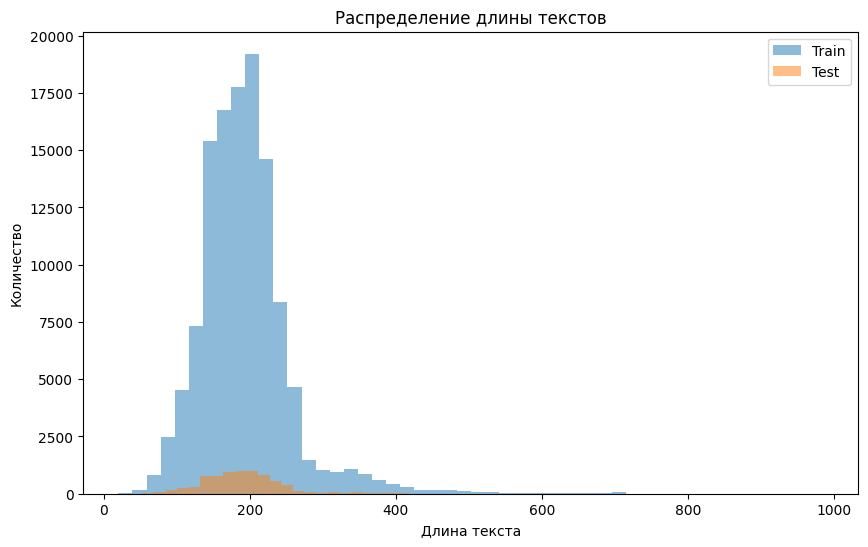

In [39]:
# Анализ длины текстов в наборе данных
train_text_lengths = train_df['description'].apply(len)
test_text_lengths = test_df['description'].apply(len)

# Вывод статистики по длине текстов
print(train_text_lengths.describe())
print(test_text_lengths.describe())

# Построение гистограммы длины текстов
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(train_text_lengths, bins=50, alpha=0.5, label='Train')
plt.hist(test_text_lengths, bins=50, alpha=0.5, label='Test')
plt.xlabel('Длина текста')
plt.ylabel('Количество')
plt.title('Распределение длины текстов')
plt.legend()
plt.show()


# Анализ уникальности слов

In [40]:
# Токенизация текстов
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['description'])

# Получение количества уникальных слов
word_index = tokenizer.word_index
num_unique_words = len(word_index)
print(f'Количество уникальных слов: {num_unique_words}')


Количество уникальных слов: 63738


# Предварительная обработка

In [41]:
# Параметры
max_words = 20000  # Количество уникальных слов для токенизации
max_len = 250  # Максимальная длина входной последовательности

# Токенизация и преобразование текстов в последовательности
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['description'])

# Преобразование текстов в последовательности
sequences_train = tokenizer.texts_to_sequences(train_df['description'])
sequences_test = tokenizer.texts_to_sequences(test_df['description'])

# Приведение последовательностей к одной длине
X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

# Преобразование меток классов в one-hot encoding
y_train = pd.get_dummies(train_df['class']).values
y_test = pd.get_dummies(test_df['class']).values



# Создание и обучение моделей

# Одномерная Сверточная Нейросеть (CNN)

Одномерные сверточные нейросети (Convolutional Neural Networks, CNN) часто используются для анализа последовательных данных. Они особенно хорошо справляются с задачами, где важны локальные паттерны (например, последовательности слов или символов).

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

Conv1D Layer (Сверточный Слой): Применяет фильтры к входным данным, извлекая локальные паттерны. В нашем случае, мы используем 128 фильтров с размером 5.

MaxPooling1D Layer (Слой Подвыборки): Уменьшает размерность данных, выбирая максимум из каждых 5 элементов, чтобы уменьшить шум и сохранить важные признаки.

GlobalMaxPooling1D Layer (Глобальный Слой Подвыборки): Еще больше уменьшает размерность, агрегируя информацию по всей последовательности.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Хорошо справляется с локальными паттернами.

Эффективность при работе с большими наборами данных.

In [42]:
# Создание модели последовательной структуры
model_cnn = Sequential()

# Добавление слоя встраивания (Embedding)
# max_words - максимальное количество уникальных слов (20000)
# 128 - размерность векторов встраивания
# max_len - максимальная длина входных последовательностей (250)
model_cnn.add(Embedding(max_words, 128, input_length=max_len))

# Добавление сверточного слоя (Conv1D)
# 128 - количество фильтров
# 5 - размер ядра свертки
# activation='relu' - функция активации ReLU
model_cnn.add(Conv1D(128, 5, activation='relu'))

# Добавление слоя подвыборки (MaxPooling1D)
# 5 - размер окна подвыборки
model_cnn.add(MaxPooling1D(5))

# Добавление слоя Dropout для регуляризации
# 0.7 - процент выключаемых нейронов
model_cnn.add(Dropout(0.7))

# Добавление слоя глобального подвыборки (GlobalMaxPooling1D)
model_cnn.add(GlobalMaxPooling1D())

# Добавление полносвязного слоя (Dense)
# 128 - количество нейронов в слое
# activation='relu' - функция активации ReLU
# kernel_regularizer=l2(0.01) - регуляризация L2 с коэффициентом 0.01
model_cnn.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

# Добавление еще одного слоя Dropout для регуляризации
# 0.7 - процент выключаемых нейронов
model_cnn.add(Dropout(0.7))

# Добавление выходного слоя (Dense)
# 4 - количество нейронов (классов)
# activation='softmax' - функция активации softmax для многоклассовой классификации
model_cnn.add(Dense(4, activation='softmax'))

# Компиляция модели
# optimizer='adam' - оптимизатор Adam
# loss='categorical_crossentropy' - функция потерь категорическая перекрестная энтропия
# metrics=['accuracy'] - метрика точности
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Настройка Early Stopping
# monitor='val_loss' - отслеживание функции потерь на валидационном наборе данных
# patience=2 - количество эпох без улучшений перед остановкой
# restore_best_weights=True - восстановление весов модели с наилучшими показателями
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Обучение модели
# epochs=50 - максимальное количество эпох обучения
# batch_size=32 - размер пакета для градиентного спуска
# validation_split=0.2 - доля валидационного набора данных
# callbacks=[early_stopping] - использование колбэков для Early Stopping
history_cnn = model_cnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50


C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.7290 - loss: 0.8548 - val_accuracy: 0.8840 - val_loss: 0.4625
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.9087 - loss: 0.3351 - val_accuracy: 0.8798 - val_loss: 0.4081
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.9257 - loss: 0.2774 - val_accuracy: 0.8813 - val_loss: 0.3827
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.9347 - loss: 0.2462 - val_accuracy: 0.8743 - val_loss: 0.3975
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 63s 21ms/step - accuracy: 0.9462 - loss: 0.2111 - val_accuracy: 0.8644 - val_loss: 0.4310


In [ ]:
# Оценка модели на тестовой выборке
# X_test - тестовый набор данных
# y_test - метки классов тестового набора данных
scores = model_cnn.evaluate(X_test, y_test, verbose=1)

# Вывод результатов оценки
print(f'Точность на тестовых данных: {scores[1]*100:.2f}%')
print(f'Потери на тестовых данных: {scores[0]:.4f}')


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8956 - loss: 0.3582
Точность на тестовых данных: 89.41%
Потери на тестовых данных: 0.3543


# Рекуррентная Нейросеть LSTM

LSTM (Long Short-Term Memory) - это разновидность рекуррентных нейросетей, которые могут обучаться и запоминать долгосрочные зависимости в последовательных данных, что делает их полезными для задач, где важен порядок и контекст.

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

LSTM Layer: Специально разработан для запоминания долгосрочных зависимостей в данных. Содержит ячейки памяти, которые могут сохранять информацию на долгое время.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Способность запоминать и учитывать долгосрочные зависимости и контексты.

Эффективность в задачах, где важен порядок элементов, например, в анализе текста или временных рядов.

In [45]:
# Создание модели последовательной структуры
model_lstm = Sequential()

# Добавление слоя встраивания (Embedding)
# max_words - максимальное количество уникальных слов (20000)
# 128 - размерность векторов встраивания
# max_len - максимальная длина входных последовательностей (250)
model_lstm.add(Embedding(max_words, 128, input_length=max_len))

# Добавление первого слоя LSTM
# 128 - количество нейронов в слое LSTM
# return_sequences=True - возвращать полные последовательности (используется при наличии последующих LSTM слоев)
model_lstm.add(LSTM(128, return_sequences=True))

# Добавление второго слоя LSTM (необязательно)
# 128 - количество нейронов в слое LSTM
# return_sequences=False - возвращать только последнее состояние (по умолчанию)
model_lstm.add(LSTM(128))

# Добавление слоя Dropout для регуляризации
# 0.7 - процент выключаемых нейронов для предотвращения переобучения
model_lstm.add(Dropout(0.7))

# Добавление полносвязного слоя (Dense)
# 128 - количество нейронов в слое
# activation='relu' - функция активации ReLU
# kernel_regularizer=l2(0.01) - регуляризация L2 с коэффициентом 0.01
model_lstm.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

# Добавление еще одного слоя Dropout для регуляризации
# 0.7 - процент выключаемых нейронов для предотвращения переобучения
model_lstm.add(Dropout(0.7))

# Добавление выходного слоя (Dense)
# 4 - количество нейронов (классов)
# activation='softmax' - функция активации softmax для многоклассовой классификации
model_lstm.add(Dense(4, activation='softmax'))

# Компиляция модели
# optimizer='adam' - оптимизатор Adam для ускорения и стабильности обучения
# loss='categorical_crossentropy' - функция потерь категорическая перекрестная энтропия для многоклассовой классификации
# metrics=['accuracy'] - метрика точности для оценки производительности модели
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Настройка Early Stopping
# monitor='val_loss' - отслеживание функции потерь на валидационном наборе данных
# patience=2 - количество эпох без улучшений перед остановкой обучения
# restore_best_weights=True - восстановление весов модели с наилучшими показателями производительности
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Обучение модели
# X_train - обучающий набор данных
# y_train - метки классов обучающего набора данных
# epochs=50 - максимальное количество эпох обучения
# batch_size=32 - размер пакета для градиентного спуска
# validation_split=0.2 - доля валидационного набора данных для оценки на каждом шаге обучения
# callbacks=[early_stopping] - использование колбэков для Early Stopping
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 657s 218ms/step - accuracy: 0.7378 - loss: 0.8024 - val_accuracy: 0.8893 - val_loss: 0.3836
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 659s 220ms/step - accuracy: 0.9156 - loss: 0.3348 - val_accuracy: 0.8970 - val_loss: 0.3508
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 634s 211ms/step - accuracy: 0.9329 - loss: 0.2682 - val_accuracy: 0.8961 - val_loss: 0.3641
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 639s 213ms/step - accuracy: 0.9465 - loss: 0.2178 - val_accuracy: 0.8909 - val_loss: 0.3947


In [46]:
# Оценка модели на тестовой выборке
# X_test - тестовый набор данных
# y_test - метки классов тестового набора данных
scores_lstm = model_lstm.evaluate(X_test, y_test, verbose=1)

# Вывод результатов оценки
print(f'Точность на тестовых данных с LSTM: {scores_lstm[1]*100:.2f}%')
print(f'Потери на тестовых данных с LSTM: {scores_lstm[0]:.4f}')

238/238 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8976 - loss: 0.3656
Точность на тестовых данных с LSTM: 90.22%
Потери на тестовых данных с LSTM: 0.3467


# Рекуррентная Нейросеть GRU

GRU (Gated Recurrent Unit) - это разновидность рекуррентных нейросетей, аналогичная LSTM, но с упрощенной архитектурой. GRU также эффективны для запоминания долгосрочных зависимостей.

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

GRU Layer: Упрощенная версия LSTM с меньшим количеством параметров. Может запоминать долгосрочные зависимости, используя механизмы затворов.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Упрощенная архитектура по сравнению с LSTM, что может привести к более быстрому обучению.

Эффективность в задачах, где важен порядок и контекст данных.

In [47]:
# Создание модели последовательной структуры
model_gru = Sequential()

# Добавление слоя встраивания (Embedding)
# max_words - максимальное количество уникальных слов (20000)
# 128 - размерность векторов встраивания
# max_len - максимальная длина входных последовательностей (250)
model_gru.add(Embedding(max_words, 128, input_length=max_len))

# Добавление первого слоя GRU
# 128 - количество нейронов в слое GRU
# return_sequences=True - возвращать полные последовательности (используется при наличии последующих GRU слоев)
model_gru.add(GRU(128, return_sequences=True))

# Добавление второго слоя GRU (необязательно)
# 128 - количество нейронов в слое GRU
# return_sequences=False - возвращать только последнее состояние (по умолчанию)
model_gru.add(GRU(128))

# Добавление слоя Dropout для регуляризации
# 0.7 - процент выключаемых нейронов для предотвращения переобучения
model_gru.add(Dropout(0.7))

# Добавление полносвязного слоя (Dense)
# 128 - количество нейронов в слое
# activation='relu' - функция активации ReLU
# kernel_regularizer=l2(0.01) - регуляризация L2 с коэффициентом 0.01
model_gru.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

# Добавление еще одного слоя Dropout для регуляризации
# 0.7 - процент выключаемых нейронов для предотвращения переобучения
model_gru.add(Dropout(0.7))

# Добавление выходного слоя (Dense)
# 4 - количество нейронов (классов)
# activation='softmax' - функция активации softmax для многоклассовой классификации
model_gru.add(Dense(4, activation='softmax'))

# Компиляция модели
# optimizer='adam' - оптимизатор Adam для ускорения и стабильности обучения
# loss='categorical_crossentropy' - функция потерь категорическая перекрестная энтропия для многоклассовой классификации
# metrics=['accuracy'] - метрика точности для оценки производительности модели
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Настройка Early Stopping
# monitor='val_loss' - отслеживание функции потерь на валидационном наборе данных
# patience=2 - количество эпох без улучшений перед остановкой обучения
# restore_best_weights=True - восстановление весов модели с наилучшими показателями производительности
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Обучение модели
# X_train - обучающий набор данных
# y_train - метки классов обучающего набора данных
# epochs=50 - максимальное количество эпох обучения
# batch_size=32 - размер пакета для градиентного спуска
# validation_split=0.2 - доля валидационного набора данных для оценки на каждом шаге обучения
# callbacks=[early_stopping] - использование колбэков для Early Stopping
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])



Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 653s 217ms/step - accuracy: 0.7159 - loss: 0.8429 - val_accuracy: 0.8933 - val_loss: 0.3511
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 660s 220ms/step - accuracy: 0.9191 - loss: 0.3233 - val_accuracy: 0.8957 - val_loss: 0.3417
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 661s 220ms/step - accuracy: 0.9383 - loss: 0.2607 - val_accuracy: 0.8905 - val_loss: 0.3855
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 670s 223ms/step - accuracy: 0.9531 - loss: 0.2095 - val_accuracy: 0.8872 - val_loss: 0.3961


In [48]:
# Оценка модели на тестовой выборке
# X_test - тестовый набор данных
# y_test - метки классов тестового набора данных
scores_gru = model_gru.evaluate(X_test, y_test, verbose=1)

# Вывод результатов оценки
print(f'Точность на тестовых данных с GRU: {scores_gru[1]*100:.2f}%')
print(f'Потери на тестовых данных с GRU: {scores_gru[0]:.4f}')


238/238 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8984 - loss: 0.3363
Точность на тестовых данных с GRU: 90.25%
Потери на тестовых данных с GRU: 0.3299


# Оценка моделей и сравнение результатов

# Точность

Точность (accuracy) – это метрика, показывающая долю правильных предсказаний модели от общего числа предсказаний. Она особенно полезна в задачах классификации и определяется как отношение числа верно предсказанных классов к общему числу примеров.

In [49]:
# Оценка точности моделей на тестовом наборе данных
cnn_acc = model_cnn.evaluate(X_test, y_test, verbose=0)[1]  # Оценка точности модели CNN на тестовом наборе данных
lstm_acc = model_lstm.evaluate(X_test, y_test, verbose=0)[1]  # Оценка точности модели LSTM на тестовом наборе данных
gru_acc = model_gru.evaluate(X_test, y_test, verbose=0)[1]  # Оценка точности модели GRU на тестовом наборе данных

# Функция для вывода итоговой точности моделей
def print_final_accuracies(model_name, train_acc, val_acc, test_acc):
    print(f'\n{model_name}')  # Вывод названия модели
    print(f'Точность на обучении: {train_acc:.2f}')  # Вывод точности модели на обучающих данных
    print(f'Точность на валидации: {val_acc:.2f}')  # Вывод точности модели на данных валидации
    print(f'Точность на тесте: {test_acc:.2f}')  # Вывод точности модели на тестовых данных

# Вывод точности моделей CNN, LSTM и GRU
cnn_train_acc = history_cnn.history['accuracy'][-1]  # Последнее значение точности на обучающих данных для модели CNN
cnn_val_acc = history_cnn.history['val_accuracy'][-1]  # Последнее значение точности на данных валидации для модели CNN
print_final_accuracies('CNN', cnn_train_acc, cnn_val_acc, cnn_acc)  # Вывод итоговой точности модели CNN

lstm_train_acc = history_lstm.history['accuracy'][-1]  # Последнее значение точности на обучающих данных для модели LSTM
lstm_val_acc = history_lstm.history['val_accuracy'][-1]  # Последнее значение точности на данных валидации для модели LSTM
print_final_accuracies('LSTM', lstm_train_acc, lstm_val_acc, lstm_acc)  # Вывод итоговой точности модели LSTM

gru_train_acc = history_gru.history['accuracy'][-1]  # Последнее значение точности на обучающих данных для модели GRU
gru_val_acc = history_gru.history['val_accuracy'][-1]  # Последнее значение точности на данных валидации для модели GRU
print_final_accuracies('GRU', gru_train_acc, gru_val_acc, gru_acc)  # Вывод итоговой точности модели GRU




CNN
Точность на обучении: 0.94
Точность на валидации: 0.86
Точность на тесте: 0.89

LSTM
Точность на обучении: 0.94
Точность на валидации: 0.89
Точность на тесте: 0.90

GRU
Точность на обучении: 0.95
Точность на валидации: 0.89
Точность на тесте: 0.90


# Потери

Функция categorical_crossentropy (категориальная кросс-энтропия) используется для многоклассовой классификации. Она измеряет разницу между истинным распределением классов (целевыми метками) и предсказанным распределением классов (выходом модели).

In [50]:
# Оценка потерь моделей на тестовом наборе данных
cnn_loss = model_cnn.evaluate(X_test, y_test, verbose=0)[0]  # Оценка потерь модели CNN на тестовом наборе данных
lstm_loss = model_lstm.evaluate(X_test, y_test, verbose=0)[0]  # Оценка потерь модели LSTM на тестовом наборе данных
gru_loss = model_gru.evaluate(X_test, y_test, verbose=0)[0]  # Оценка потерь модели GRU на тестовом наборе данных

# Функция для вывода итоговых потерь моделей
def print_final_losses(model_name, train_loss, val_loss, test_loss):
    print(f'\n{model_name}')  # Вывод названия модели
    print(f'Потери на обучении: {train_loss:.4f}')  # Вывод потерь модели на обучающих данных
    print(f'Потери на валидации: {val_loss:.4f}')  # Вывод потерь модели на данных валидации
    print(f'Потери на тесте: {test_loss:.4f}')  # Вывод потерь модели на тестовых данных

# Вывод потерь моделей CNN, LSTM и GRU
cnn_train_loss = history_cnn.history['loss'][-1]  # Последнее значение потерь на обучающих данных для модели CNN
cnn_val_loss = history_cnn.history['val_loss'][-1]  # Последнее значение потерь на данных валидации для модели CNN
print_final_losses('CNN', cnn_train_loss, cnn_val_loss, cnn_loss)  # Вывод итоговых потерь модели CNN

lstm_train_loss = history_lstm.history['loss'][-1]  # Последнее значение потерь на обучающих данных для модели LSTM
lstm_val_loss = history_lstm.history['val_loss'][-1]  # Последнее значение потерь на данных валидации для модели LSTM
print_final_losses('LSTM', lstm_train_loss, lstm_val_loss, lstm_loss)  # Вывод итоговых потерь модели LSTM

gru_train_loss = history_gru.history['loss'][-1]  # Последнее значение потерь на обучающих данных для модели GRU
gru_val_loss = history_gru.history['val_loss'][-1]  # Последнее значение потерь на данных валидации для модели GRU
print_final_losses('GRU', gru_train_loss, gru_val_loss, gru_loss)  # Вывод итоговых потерь модели GRU



CNN
Потери на обучении: 0.2242
Потери на валидации: 0.4310
Потери на тесте: 0.3543

LSTM
Потери на обучении: 0.2274
Потери на валидации: 0.3947
Потери на тесте: 0.3467

GRU
Потери на обучении: 0.2220
Потери на валидации: 0.3961
Потери на тесте: 0.3299


# Построение графиков

Точность и потери

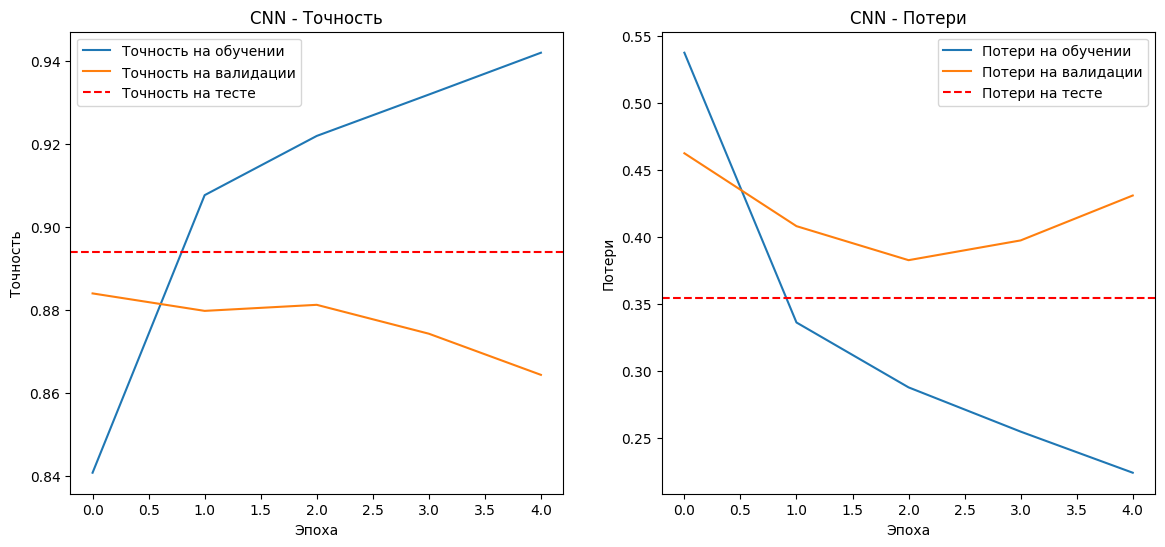

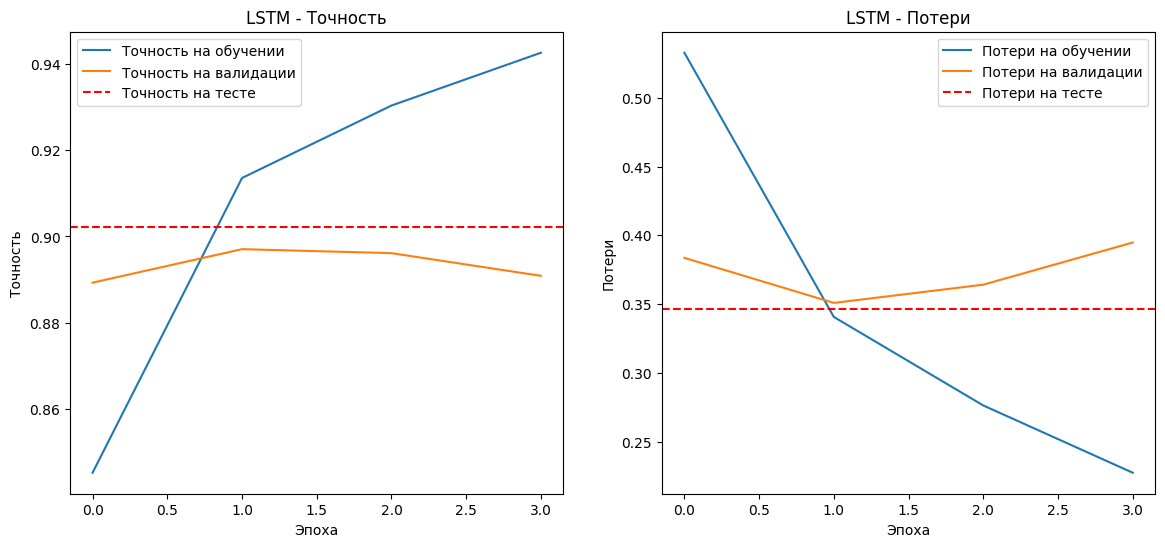

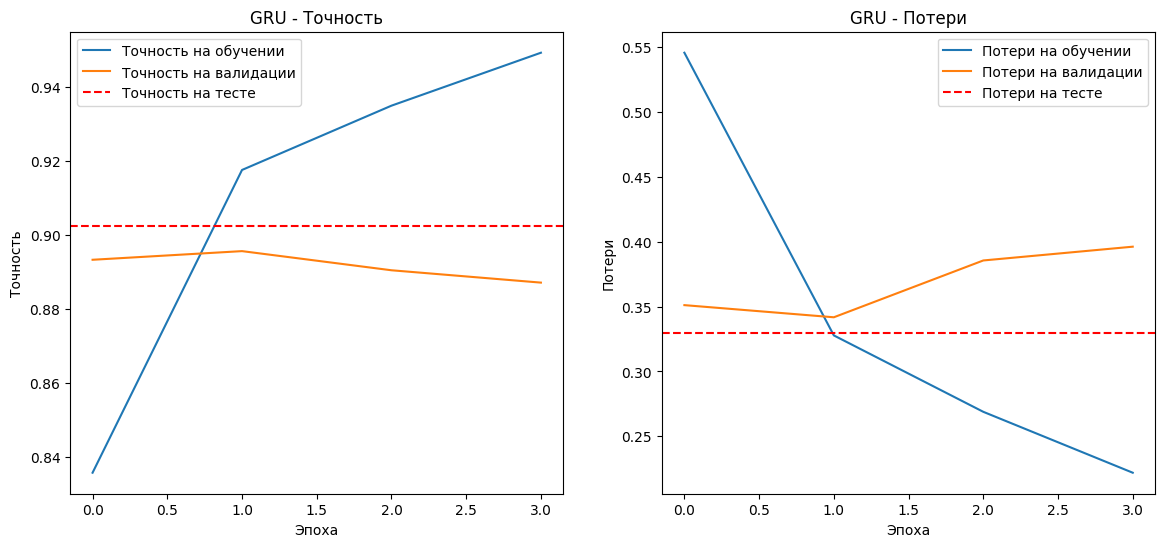

In [51]:
# Функция для построения графиков обучения и потерь
def plot_full_training_history(history, model_name, test_acc, test_loss):
    plt.figure(figsize=(14, 6))

    # График точности
    plt.subplot(1, 2, 1)  # Создание подграфика (1 из 2) для точности
    plt.plot(history.history['accuracy'], label='Точность на обучении')  # Построение графика точности на обучении
    plt.plot(history.history['val_accuracy'], label='Точность на валидации')  # Построение графика точности на валидации
    plt.axhline(y=test_acc, color='r', linestyle='--', label='Точность на тесте')  # Добавление точности на тесте как горизонтальной линии
    plt.title(f'{model_name} - Точность')  # Установка заголовка графика
    plt.xlabel('Эпоха')  # Установка метки оси X
    plt.ylabel('Точность')  # Установка метки оси Y
    plt.legend()  # Добавление легенды к графику

    # График потерь
    plt.subplot(1, 2, 2)  # Создание подграфика (2 из 2) для потерь
    plt.plot(history.history['loss'], label='Потери на обучении')  # Построение графика потерь на обучении
    plt.plot(history.history['val_loss'], label='Потери на валидации')  # Построение графика потерь на валидации
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Потери на тесте')  # Добавление потерь на тесте как горизонтальной линии
    plt.title(f'{model_name} - Потери')  # Установка заголовка графика
    plt.xlabel('Эпоха')  # Установка метки оси X
    plt.ylabel('Потери')  # Установка метки оси Y
    plt.legend()  # Добавление легенды к графику

    # Отображение графиков
    plt.show()

# Построение графиков для каждой модели
plot_full_training_history(history_cnn, 'CNN', cnn_acc, cnn_loss)
plot_full_training_history(history_lstm, 'LSTM', lstm_acc, lstm_loss)
plot_full_training_history(history_gru, 'GRU', gru_acc, gru_loss)



# Выводы:
Корректировка и добавление гиперпараметров позволили улучшить качество обучения моделей, однако значительно увеличить время обучения (более, чем в 2 раза).